In [2]:
import os
os.chdir("..")
print(os.getcwd())

import sys
from pathlib import Path
from importlib import reload

/hs/fs08/data/group-brueggen/tmartinez/diffusion/src


## BDSF Analysis

### BDSF Metrics Correlations

In [3]:
import analysis.bdsf_evaluation as bdsfeval
import utils.paths as paths

metrics = bdsfeval.get_metric_dict(paths.LOFAR_SUBSETS['0-clip_unscaled'])

Found existing distribution file for lofar_120asLimit_80p_0-clipped_f-thr=0_SNR>=5_subset.hdf5.


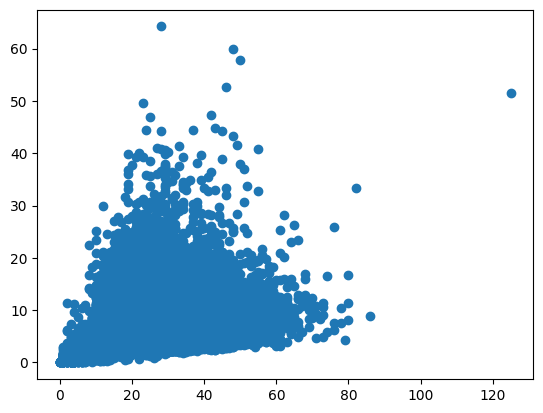

In [9]:
import matplotlib.pyplot as plt

plt.scatter(metrics['ngaus'], metrics['total_flux_gaus'])
#plt.ylim(0, 150)

### BDSF Run Implementation

In [ ]:
import sys, os
import pickle
import dill
import tempfile
from collections.abc import Iterable
from numbers import Number

from astropy.io import fits
import bdsf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import utils.paths as paths

# decorater used to block function printing to the console
def blockPrinting(func):
    def func_wrapper(*args, **kwargs):
        # block all printing to the console
        sys.stdout = open(os.devnull, 'w')
        # call the method in question
        value = func(*args, **kwargs)
        # enable all printing to the console
        sys.stdout = sys.__stdout__
        # pass the return value of the method back
        return value

    return func_wrapper

@blockPrinting
def bdsf_on_image(img: np.ndarray):
    '''
    Run bdsf on a single image.
    '''
    # Set up the header, which contains information required for bdsf
    beam_size = 0.001666  # 6 arcsec
    # Angular size of the images is 50 arcsec, pixel size is 80x80.
    # Pixel size in deg:
    px_size_deg = 50 / 3600 / 80
    header_dict = {
        "CDELT1": -px_size_deg,  # Pixel size in deg (1,5 arcsec)
        "CUNIT1": "deg",
        "CTYPE1": "RA---SIN",
        "CDELT2": px_size_deg,
        "CUNIT2": "deg",
        "CTYPE2": "DEC--SIN",
        "CRVAL4": 143650000.0,  # Frequency in Hz
        "CUNIT4": "HZ",
        "CTYPE4": "FREQ",
    }

    # Set up hdu with header and image data for temporary fits file,
    # because bdsf only accepts fits files
    hdu = fits.PrimaryHDU(data=img, header=fits.Header(header_dict))

    # Create a temporary file
    with tempfile.NamedTemporaryFile(suffix='.fits') as f:

        # Write the hdu to tmp fits file
        fits.HDUList([hdu]).writeto(f.name, overwrite=True)

        # Run bdsf on the fits file
        img = bdsf.process_image(
            f.name,
            thresh_isl=1.5,
            thresh_pix=0.5,
            beam=(beam_size, beam_size, 0),
            mean_map='const',
            rms_map=False,
            thresh='hard',
            quiet=True,
        )
    
    # Return bdsf image object
    return img

def catalogs_from_bdsf(img: bdsf.image.Image):
    cat_list = []

    # Loop through both cat types
    for cat_type in ['gaul', 'srl']:

        # Create a temporary csv file
        with tempfile.NamedTemporaryFile(suffix='.csv') as f:

            # Write the catalog to the csv file
            img.write_catalog(
                outfile=f.name,
                clobber=True,
                catalog_type=cat_type,
                format='csv',
            )

            # Read the csv file
            catalog = pd.read_csv(f.name, skiprows=5)

            # Append to list
            cat_list.append(catalog)

    return cat_list

def dict_from_bdsf(img: bdsf.image.Image):
    # Get all attributes of the bdsf image object
    # that are numbers or numpy arrays
    d = {
        k: v for k, v in img.__dict__.items()
        if isinstance(v, Number) or isinstance(v, np.ndarray)
    }
    return d

def bdsf_run(
        imgs: Iterable,
        out_folder: str | Path,
        out_parent=paths.ANALYSIS_PARENT,
        ):
    '''
    Run bdsf on a set of images and save the resulting list as pickle file.
    '''
    # Set up the output folder
    out_path = out_parent / out_folder
    out_path.mkdir(exist_ok=True)

    # Set up lists that will be filled with the output
    dicts, cats_gaul, cats_srl = [], [], []

    # Run bdsf on all images
    for i, img in enumerate(tqdm(imgs)):

        # Run bdsf on the image
        bdsf_img = bdsf_on_image(img)

        # Retrieve the desired attributes of the bdsf image object & add to list
        dicts.append(dict_from_bdsf(bdsf_img))

        # Retrieve the catalogs of the bdsf image object
        cats_g, cats_s = catalogs_from_bdsf(bdsf_img)

        # Add loop index to the catalogs
        cats_g['Image_id'] = i
        cats_s['Image_id'] = i

        # Append to list
        cats_gaul.append(cats_g)
        cats_srl.append(cats_s)

    # Save the list with attribute dicts as pickle file
    with open(out_path / f'{out_folder}_bdsf_dicts.pkl', 'wb') as f:
        pickle.dump(dicts, f)

    # Concatenate the catalogs and save as csv
    cat_gaul = pd.concat(cats_gaul)
    cat_gaul.to_csv(out_path / f'{out_folder}_bdsf_gaul.csv', index=False)

    cat_srl = pd.concat(cats_srl)
    cat_srl.to_csv(out_path / f'{out_folder}_bdsf_srl.csv', index=False)

    return dicts, cat_gaul, cat_srl


def bdsf_plot(
        img,
        keys=['ch0_arr', 'resid_gaus_arr', 'model_gaus_arr']
        ):
    fig = plt.figure(figsize=(10, 15))
    for i, key in enumerate(keys):
        # add subplot
        ax = fig.add_subplot(1, len(keys), i + 1)
        image = getattr(img, key)
        ax.imshow(image.T)
        ax.set_title(key)
        ax.set_axis_off()
    fig.show()

In [ ]:
from utils.data_utils import EvaluationDataset
import utils.paths as paths
from utils.paths import LOFAR_SUBSETS

# Load the dataset
dataset = EvaluationDataset(LOFAR_SUBSETS['unclipped_SNR>=5_50asLimit'])

n = 1
# Pick n**2 random images
idxs = np.random.choice(len(dataset), n**2, replace=False)
images = [dataset[i].squeeze() for i in idxs]

# Run bdsf on the images
bdsf_out = bdsf_on_image(images[0])

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


In [ ]:
bdsf_out.opts.quiet

False

In [ ]:
bdsf_out[2].write_catalog(
    outfile=str(paths.PLAYGORUND_DIR / 'bdsf_test_catalog.csv'),
    format='csv',
    catalog_type='srl',
    clobber=True,
)

True

In [ ]:
type(bdsf_out[0])

bdsf.image.Image

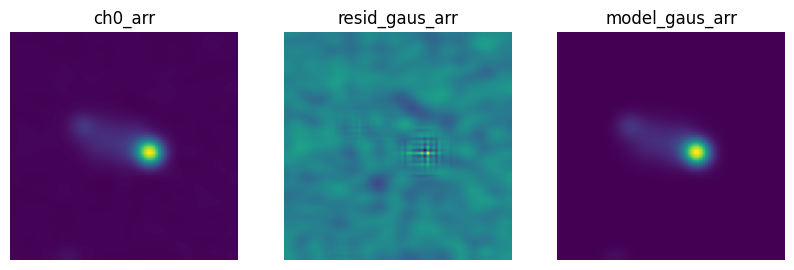

In [ ]:
bdsf_plot(bdsf_out[2])

In [ ]:
import pandas as pd

# Load the catalog
catalog = pd.read_csv(
    paths.PLAYGORUND_DIR / 'bdsf_test_catalog.csv',
    skiprows=5, skipinitialspace=True
    )
catalog.columns

Index(['# Source_id', 'Isl_id', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Total_flux',
       'E_Total_flux', 'Peak_flux', 'E_Peak_flux', 'RA_max', 'E_RA_max',
       'DEC_max', 'E_DEC_max', 'Maj', 'E_Maj', 'Min', 'E_Min', 'PA', 'E_PA',
       'Maj_img_plane', 'E_Maj_img_plane', 'Min_img_plane', 'E_Min_img_plane',
       'PA_img_plane', 'E_PA_img_plane', 'DC_Maj', 'E_DC_Maj', 'DC_Min',
       'E_DC_Min', 'DC_PA', 'E_DC_PA', 'DC_Maj_img_plane',
       'E_DC_Maj_img_plane', 'DC_Min_img_plane', 'E_DC_Min_img_plane',
       'DC_PA_img_plane', 'E_DC_PA_img_plane', 'Isl_Total_flux',
       'E_Isl_Total_flux', 'Isl_rms', 'Isl_mean', 'Resid_Isl_rms',
       'Resid_Isl_mean', 'S_Code'],
      dtype='object')

In [ ]:
catalog

,# Gaus_id,Isl_id,Source_id,Wave_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,...,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code
0,0,2,0,0,359.990910,1.626763e-07,0.013011,1.489940e-07,0.395170,0.000268,...,3.445987e-07,0.0,0.243584,0.824935,0.00076,0.000303,0.005461,0.081691,0.05469,M
1,1,2,0,0,359.991836,3.482172e-07,0.013869,2.959719e-07,0.130241,0.000216,...,6.431127e-07,0.0,0.236200,0.824935,0.00076,0.000303,0.005461,0.081691,0.05469,M


In [ ]:
bdsf_out[0].__dict__

{'_prev_opts': {'advanced_opts': False,
  'atrous_do': False,
  'beam': (0.001666, 0.001666, 0.0),
  'filename': '/tmp/tmplhxw04v6.fits',
  'flagging_opts': False,
  'frequency': None,
  'interactive': False,
  'mean_map': 'const',
  'multichan_opts': False,
  'output_opts': False,
  'polarisation_do': False,
  'psf_vary_do': False,
  'rm_do': False,
  'rms_box': None,
  'rms_map': False,
  'shapelet_do': False,
  'spectralindex_do': False,
  'thresh': 'hard',
  'thresh_isl': 1.5,
  'thresh_pix': 0.5,
  'adaptive_rms_box': False,
  'split_isl': True,
  'splitisl_maxsize': 50.0,
  'splitisl_size_extra5': 0.1,
  'splitisl_frac_bigisl3': 0.8,
  'peak_fit': True,
  'peak_maxsize': 30.0,
  'fdr_alpha': 0.05,
  'fdr_ratio': 0.1,
  'kappa_clip': None,
  'bmpersrc_th': None,
  'spline_rank': 3,
  'minpix_isl': None,
  'maxpix_isl': None,
  'rms_value': None,
  'aperture': None,
  'aperture_posn': 'centroid',
  'src_ra_dec': None,
  'src_radius_pix': None,
  'ini_gausfit': 'default',
  'ini_met

In [ ]:
from numbers import Number

d = {
    k: v for k, v in bdsf_out[0].__dict__.items()
    if isinstance(v, Number) or isinstance(v, np.ndarray)
}

with open(paths.PLAYGORUND_DIR / 'bdsf_img_dict.pkl', 'wb') as f:
    pickle.dump(d, f)

In [ ]:
with open(paths.PLAYGORUND_DIR / 'bdsf_img_dict.pkl', 'rb') as f:
    d_pkl = pickle.load(f)

In [ ]:
d_pkl['model_gaus_arr'].max()

0.986594

### BDSF on Training Data

In [4]:
# Import analysis results for testing
import utils.paths as paths
from utils.data_utils import EvaluationDataset

subset_path = paths.LOFAR_SUBSETS['0-clip_unscaled']
parent = paths.ANALYSIS_PARENT / subset_path.stem / 'bdsf'

dicts_dir = parent / 'dicts' 
gaul_file, srl_file = sorted(parent.glob('*.csv'))

dataset = EvaluationDataset(subset_path)

Loading images...
Data set initialized.


In [5]:
import pickle

def load_single_pickle(f):
    with open(f, 'rb') as f:
        return pickle.load(f)
    
# Load the dicts
bdsf_dicts = list(map(load_single_pickle, sorted(dicts_dir.glob('*.pkl'))))

In [6]:
len(bdsf_dicts), len(dataset)

(102325, 102325)

In [ ]:
def get_elements(dcts, key):
    return [d[key] for d in dcts]
    

In [ ]:
bdsf_dicts[0].keys()

dict_keys(['model_gaus_arr', 'total_flux_gaus', 'ngaus', 'nsrc', 'Image_id'])

In [ ]:
keys = [
    'ngaus', 'nsrc', 'total_flux_gaus', 'Image_id'
]

stats = {k: get_elements(bdsf_dicts, k) for k in keys}

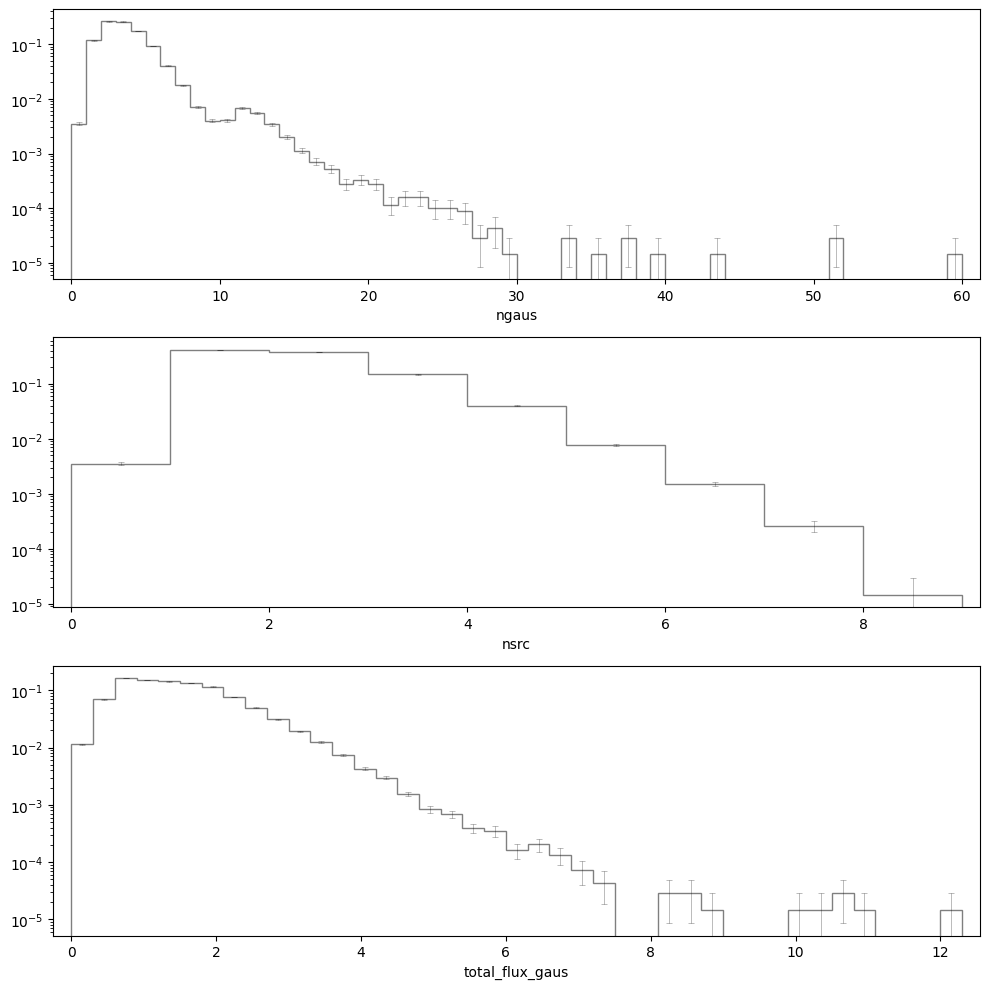

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from utils.plot_utils import add_distribution_plot

# Bins dictionary that sets the histogram bins for each quantity.
bins_dict = {
    'ngaus': np.linspace(0, 60, 61),
    'nsrc': np.linspace(0, 10, 11),
    'total_flux_gaus': np.linspace(0, 15, 51),
}

fig, axs = plt.subplots(len(stats)-1, 1, figsize=(10, 10), tight_layout=True)

for i, (k, v) in enumerate(stats.items()):

    # Don't plot Image_id
    if k == 'Image_id':
        continue

    counts, edges = np.histogram(v, bins=bins_dict[k])
    add_distribution_plot(
        counts, edges, axs[i]
    )
    axs[i].set_xlabel(k)
    axs[i].set_yscale('log')

In [ ]:
from matplotlib import colormaps as cm
from scipy.optimize import fminbound
from tqdm import tqdm

def errfn(q, img_arr, p_target):
    p = img_arr[img_arr >= q].sum() / img_arr.sum()
    return (p - p_target)**2

def quantile_values(img_arr, p_vals):
    return np.array([
        fminbound(errfn, 0, img_arr.max(), args=(img_arr, p_target), disp=0)
        for p_target in p_vals
    ])

def quantile_area(img_arr, p_vals, q_vals=None):
    if q_vals is None:
        q_vals = quantile_values(img_arr, p_vals)
    return [np.sum(img_arr>=q) for q in q_vals]

def quantile_value_img_list(img_list, p_vals):
    out = []
    for img in tqdm(img_list, desc="Calculating quantiles"):
        out.append(quantile_values(img, p_vals))
    return np.stack(out)

def quantile_area_image_list(img_list, p_vals, q_vals_list=None):
    if q_vals_list is None:
        q_vals_list = quantile_value_img_list(img_list, p_vals)
    return np.stack([
        quantile_area(img, p_vals, q_vals=q_vals)
         for img, q_vals in tqdm(zip(img_list, q_vals_list), total=len(img_list))
    ])

def quantile_contour_plot(img_arr, p_vals=[0.9, 0.5, 0.1], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
    q_vals = quantile_values(img_arr, p_vals)

    ax.imshow(img_arr)
    ax.axis('off')
    cnt = ax.contour(
        img_arr, levels=np.unique(q_vals), colors=cm['PiYG'](p_vals), linewidths=0.5
    )
    ax.clabel(
        cnt, inline=True, fontsize=8, fmt={q: p for q, p in zip(q_vals, p_vals)}
    )
    
    if ax is None:
        plt.show()
    return q_vals

In [ ]:
# This will be in the right order only if the pickel files are sorted 
# during loading
gaus_imgs = np.stack(get_elements(bdsf_dicts, 'model_gaus_arr'))

In [ ]:
pvals = [0.9, 0.5, 0.1]
qvals = quantile_value_img_list(gaus_imgs, pvals);

Calculating quantiles:   0%|          | 0/68976 [00:00<?, ?it/s]/tmp/ipykernel_1889429/1264368575.py:6: RuntimeWarning: invalid value encountered in scalar divide
  p = img_arr[img_arr >= q].sum() / img_arr.sum()
Calculating quantiles: 100%|██████████| 68976/68976 [01:12<00:00, 949.57it/s] 


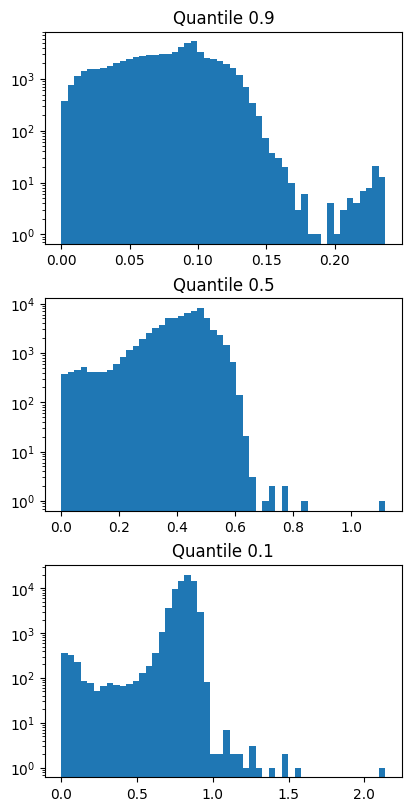

In [ ]:
fig, axs = plt.subplots(len(pvals), 1, figsize=(4, 8), constrained_layout=True)

for p, q, ax in zip(pvals, qvals.T, axs):
    ax.hist(q, bins=50)
    ax.set_yscale('log')
    ax.set_title(f'Quantile {p}')

In [ ]:
qvals.shape

(68976, 3)

25


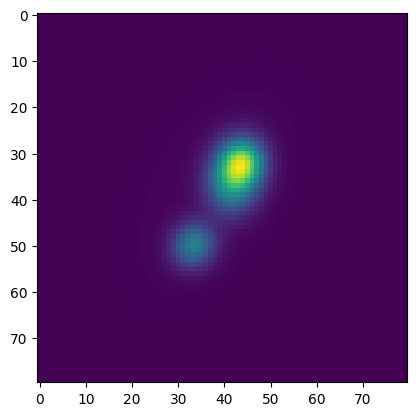

In [ ]:
# Look for images with 0.9-quantile value of 1
idxs = np.where(qvals[:, 2] >= 1)[0]
print(len(idxs))

img = gaus_imgs[idxs][1]
plt.imshow(img)

234.76773 1.4355378


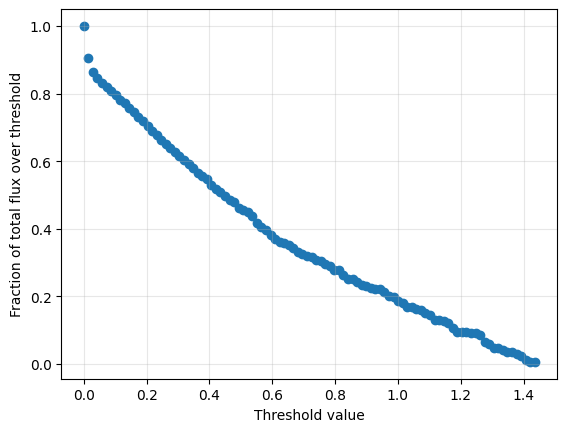

In [ ]:
tot = img.sum()
print(tot, img.max())
frac = lambda q: np.sum(img[img >= q]) / tot

qs = np.linspace(0, img.max(), 100)
frac_arr = np.array([frac(q) for q in qs])

plt.scatter(qs, frac_arr)
plt.xlabel('Threshold value')
plt.ylabel('Fraction of total flux over threshold')
plt.grid(alpha=0.3)

In [ ]:
pvals = [0.9, 0.5, 0.1]
avals = quantile_area_image_list(gaus_imgs, pvals, q_vals_list=qvals)

100%|██████████| 68976/68976 [00:01<00:00, 39319.29it/s]


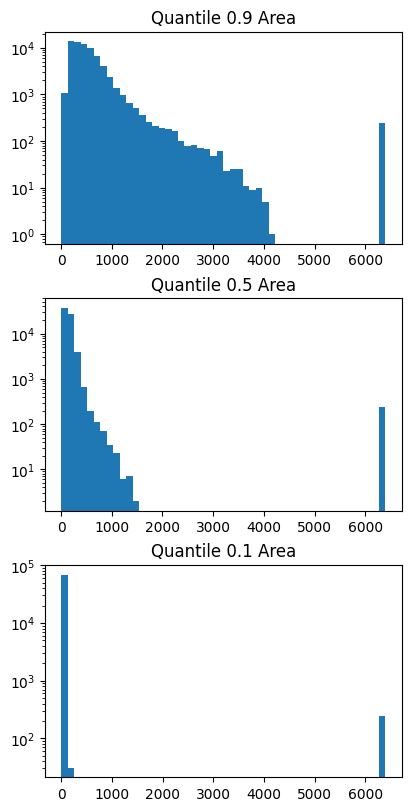

In [ ]:
fig, axs = plt.subplots(len(pvals), 1, figsize=(4, 8), constrained_layout=True)

for p, q, ax in zip(pvals, avals.T, axs):
    ax.hist(q, bins=50)
    ax.set_yscale('log')
    ax.set_title(f'Quantile {p} Area')

242


/tmp/ipykernel_1889429/1264368575.py:6: RuntimeWarning: invalid value encountered in scalar divide
  p = img_arr[img_arr >= q].sum() / img_arr.sum()


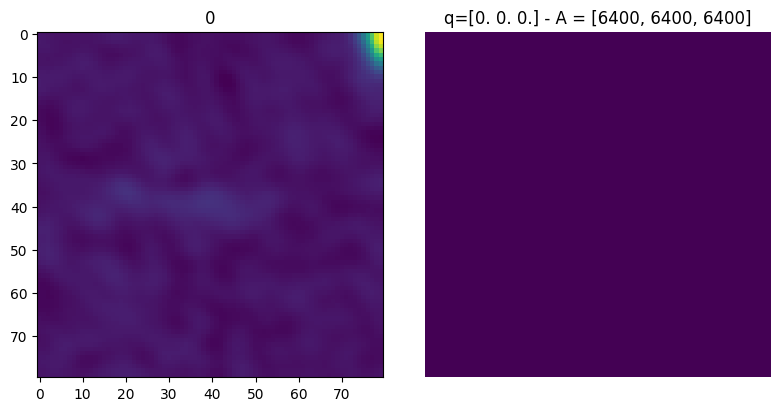

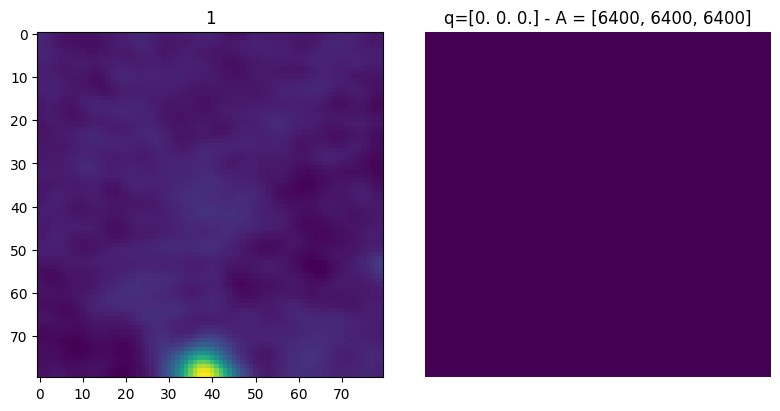

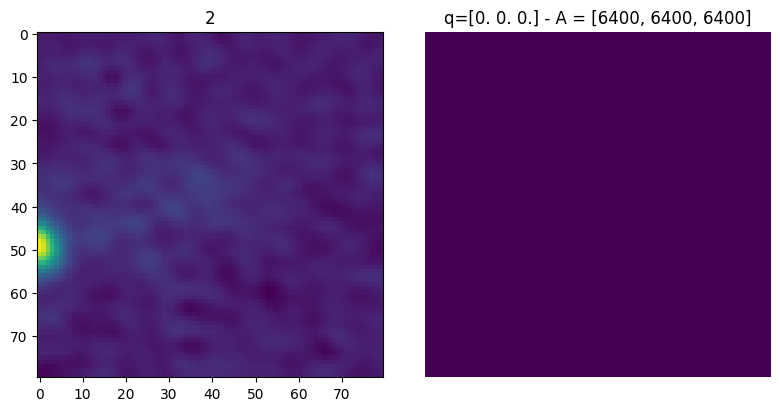

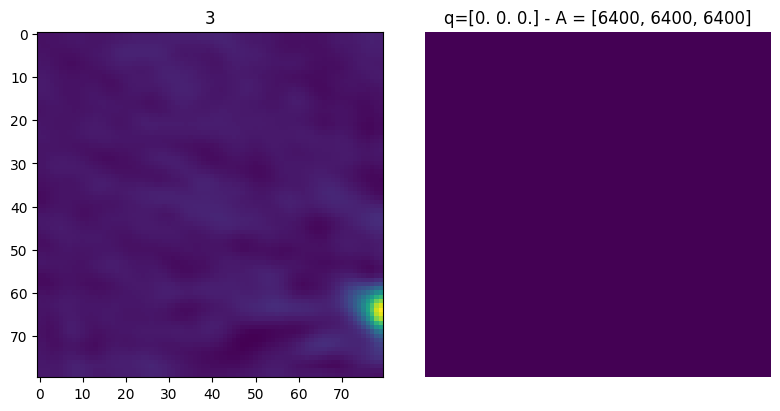

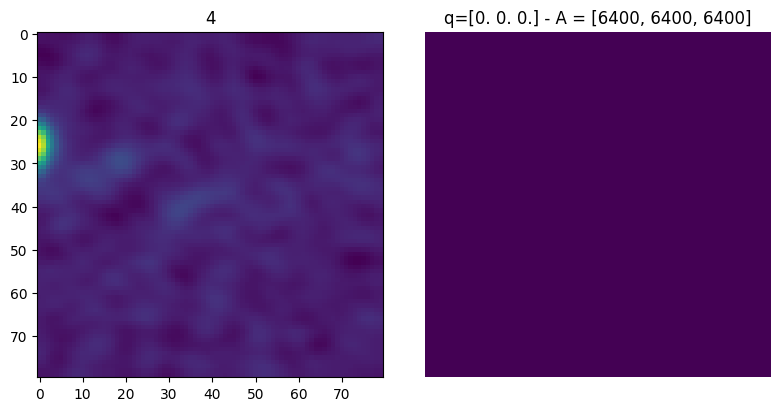

In [ ]:
# Look at outliers for .9 quantile area
mask = avals.T[0] > 6000
print(mask.sum())

n_plots = 5

for i, (ch0, gaus) in enumerate(zip(dataset.data[mask][:n_plots], gaus_imgs[mask][:n_plots])):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    axs[0].imshow(ch0)
    axs[0].set_title(i)
    q_vals = quantile_contour_plot(gaus.T, pvals, ax=axs[1])
    axs[1].set_title(f"q={q_vals} - A = {quantile_area(gaus, pvals, q_vals=q_vals)}")
    plt.show()

In [ ]:
imgs_masked = dataset.data[mask]
imgs_rest = dataset.data[~mask]

def edge_pixels(img):
    return np.concatenate([img[0], img[-1], img[1:-1, 0], img[1:-1, -1]])

edge_pixels_masked = np.stack([edge_pixels(img) for img in imgs_masked])
edge_pixels_rest = np.stack([edge_pixels(img) for img in imgs_rest])
edge_pixels_all = np.stack([edge_pixels(img) for img in dataset.data])

In [ ]:
edge_pixels_masked.shape, edge_pixels_rest.shape

((242, 320), (68734, 320))

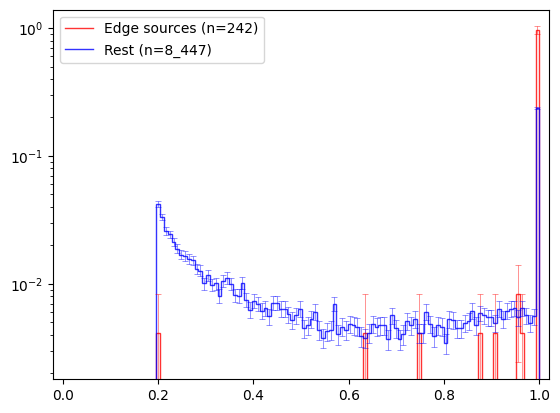

In [ ]:
from utils.plot_utils import add_distribution_plot

fig, ax = plt.subplots()

c, e = np.histogram(edge_pixels_masked.max(axis=1), bins=100)
add_distribution_plot(c, e, ax, label='Edge sources', color='r', alpha=0.8)

c, e = np.histogram(edge_pixels_rest.max(axis=1), bins=e)
add_distribution_plot(c, e, ax, label='Rest', color='b', alpha=0.8)

ax.set_yscale('log')
ax.legend()

fig.show()

In [ ]:
thresh = 0.8
edge_mask = edge_pixels_all.max(axis=1) > thresh
edge_mask.sum()


3350

In [ ]:
cut_ratios = []
for thresh in np.linspace(0, 1, 100):
    edge_mask = edge_pixels_all.max(axis=1) > thresh
    cut_ratios.append(edge_mask.sum() / len(edge_mask))

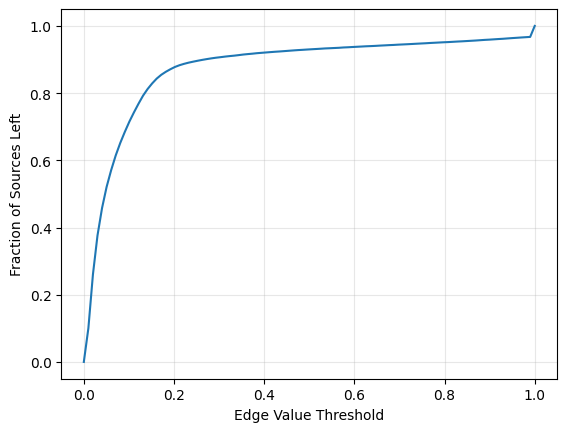

In [ ]:
plt.plot(np.linspace(0, 1, 100), 1 - np.array(cut_ratios))
plt.xlabel('Edge Value Threshold')
plt.ylabel('Fraction of Sources Left')
plt.grid(alpha=0.3)
plt.show()

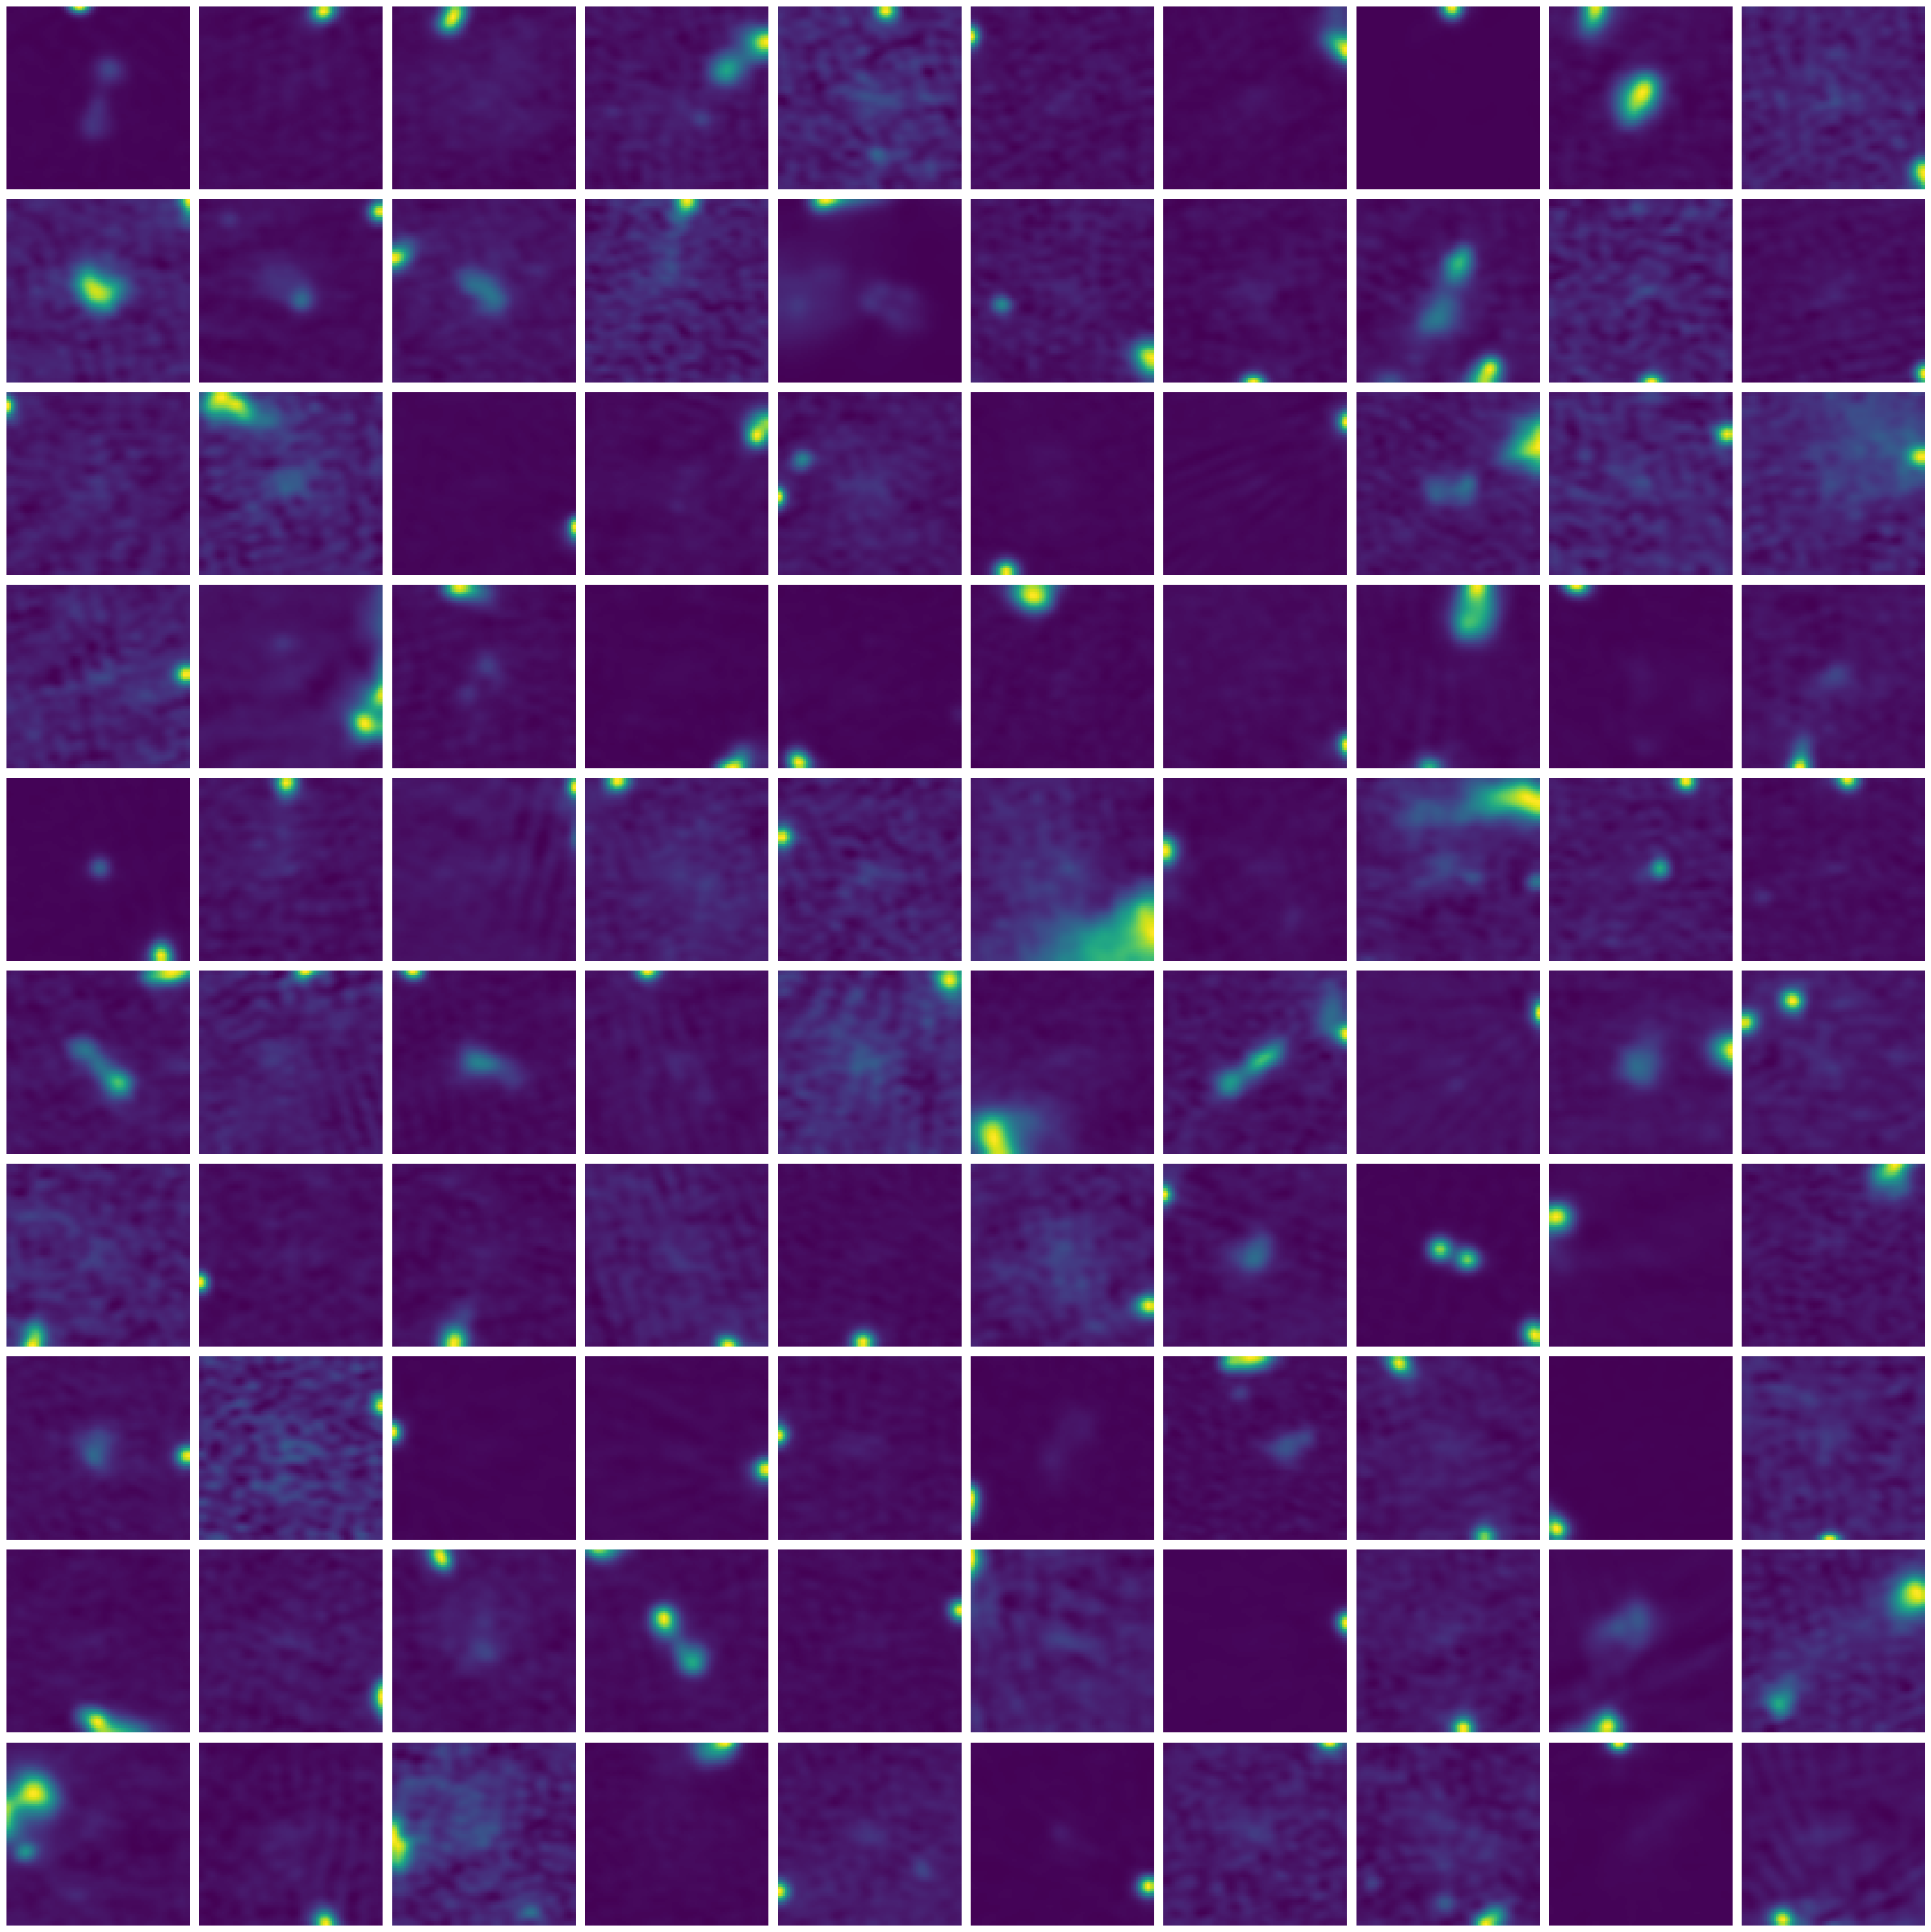

In [ ]:
from utils.plot_utils import plot_image_grid

edge_sources = dataset.data[edge_mask]

# Pick random edge sources
n = 10
idxs = np.random.choice(len(edge_sources), n**2, replace=False)

plot_image_grid(edge_sources[idxs], vmin=0);

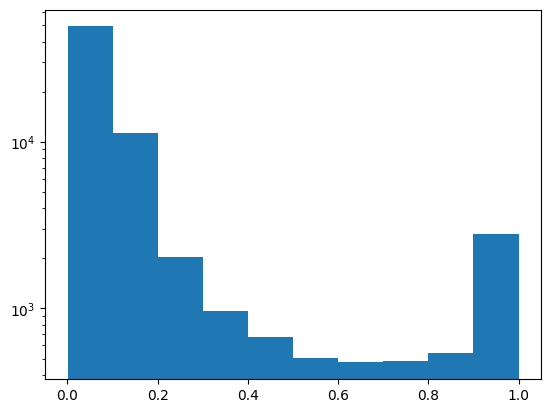

In [ ]:
plt.hist(edge_pixels_all.max(axis=1))
plt.yscale('log')

### BDSF on Generated Data

In [ ]:
import utils.paths as paths

img_file = paths.ANALYSIS_PARENT / 'EDM_SNR5_50as/EDM_SNR5_50as_samples_10000Imgs_T=25.pt'
bdsf_pkl_dir = paths.ANALYSIS_PARENT / img_file.stem

In [ ]:
# Load images
from utils.data_utils import EvaluationDataset

dataset = EvaluationDataset(img_file)

Data set initialized.


In [ ]:
# Look at images that were not processed due to 'unphysical rms value'
import pandas as pd

log_file = bdsf_pkl_dir / 'writer_log.txt'
log_df = pd.read_csv(log_file, names=['Job_id', 'Image_id'],)
log_df

,Job_id,Image_id
0,0,320
1,1,700
2,2,620
3,3,50
4,4,150
...,...,...
9992,9992,7385
9993,9993,7386
9994,9994,7387
9995,9995,7388


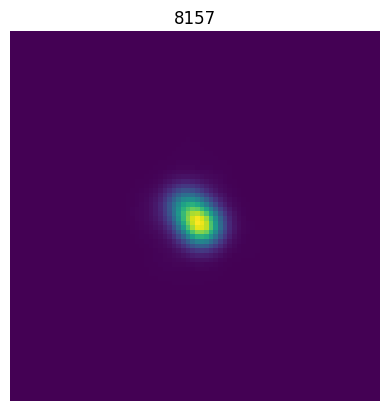

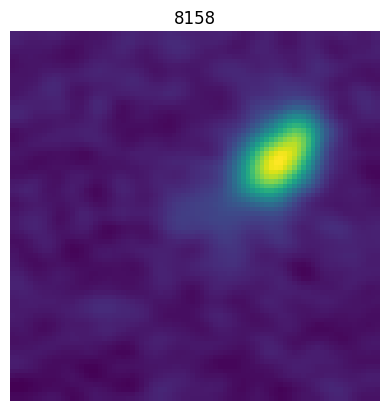

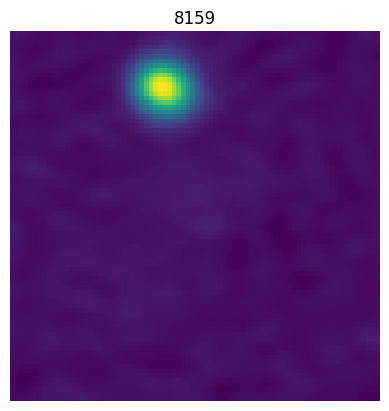

In [ ]:
missing = list(set(dataset.names) - set(log_df.Image_id))

# Pick missing images and plot
import matplotlib.pyplot as plt
import numpy as np

missing_imgs = [dataset[np.argwhere(dataset.names == name).squeeze()].numpy() for name in missing]

for img, name in zip(missing_imgs, missing):
    plt.imshow(img.squeeze())
    plt.title(name)
    plt.axis('off')
    plt.show()

### BDSF Distribution Analysis Implementation

Procedure:
- Import results from folder
- Calculate distributions of parameters
- Save distributions to dict
- Create plot and add info from dict

In [ ]:
import pickle
import numpy as np
from tqdm import tqdm


def get_elements(dcts, key):
    # Return the values of a key from a list of dicts as np array
    return np.array([d[key] for d in dcts])

def load_bdsf_metric_dict(bdsf_pkl_dir):

    # Function for loading single pickle file
    def load_single_pickle(f):
        with open(f, 'rb') as f:
            return pickle.load(f)
        
    # Load the dicts, which are stored as single pickle files each
    bdsf_dicts = list(
        map(load_single_pickle, tqdm(sorted(bdsf_pkl_dir.glob('*.pkl'))))
    )

    # Merge them to one single dict with arrays as values
    out_dict = {k: get_elements(bdsf_dicts, k) for k in tqdm(bdsf_dicts[0].keys())}
    return out_dict

In [ ]:
from matplotlib import colormaps as cm
from scipy.optimize import fminbound
from tqdm import tqdm

def errfn(q, img_arr, p_target):
    p = img_arr[img_arr >= q].sum() / img_arr.sum()
    return (p - p_target)**2

def quantile_values(img_arr, p_vals):
    return np.array([
        fminbound(errfn, 0, img_arr.max(), args=(img_arr, p_target), disp=0)
        for p_target in p_vals
    ])

def quantile_area(img_arr, p_vals, q_vals=None):
    if q_vals is None:
        q_vals = quantile_values(img_arr, p_vals)
    return [np.sum(img_arr>=q) for q in q_vals]

def quantile_value_img_list(img_list, p_vals):
    out = []
    for img in tqdm(img_list, desc="Calculating quantiles"):
        out.append(quantile_values(img, p_vals))
    return np.stack(out)

def quantile_area_image_list(img_list, p_vals, q_vals_list=None):
    if q_vals_list is None:
        q_vals_list = quantile_value_img_list(img_list, p_vals)
    return np.stack([
        quantile_area(img, p_vals, q_vals=q_vals)
         for img, q_vals in tqdm(zip(img_list, q_vals_list), total=len(img_list))
    ])

def add_quantile_areas(bdsf_metric_dict):
    pvals = [0.9, 0.5, 0.1]
    avals = quantile_area_image_list(bdsf_metric_dict['model_gaus_arr'], pvals)
    for p, q in zip(pvals, avals.T):
        bdsf_metric_dict[f'q{p}_area'] = q
    return bdsf_metric_dict

In [ ]:
def bdsf_distributions_from_metrics(metrics_dict, bins: dict = {}):
    # Define bins for distributions
    bins_dict = {
        'ngaus': np.linspace(0, 60, 61),
        'nsrc': np.linspace(0, 10, 11),
        'total_flux_gaus': np.linspace(0, 15, 51),
        'q0.9_area': np.linspace(0, 6400, 257),
        'q0.5_area': np.linspace(0, 6400, 257),
        'q0.1_area': np.linspace(0, 6400, 257),
    }

    # Copy metrics dict and remove unnecessary keys
    metrics_dict = metrics_dict.copy()

    # Update bins dict with user-specified bins
    if len(bins):
        # Assert keys are contained in bins dict
        assert all([key in bins_dict.keys() for key in bins.keys()]), \
            f"Unknown key in bins dict:"\
            f" {set(bins.keys()) - set(bins_dict.keys())}"
        bins_dict.update(bins)

    # Assert keys of bins_dict are in metrics_dict
    assert set(bins_dict.keys()) <= set(metrics_dict.keys()), \
        f"Keys of bins dict and metrics dict do not match:"\
        f" {set(bins_dict.keys()) - set(metrics_dict.keys())}"

    # Calculate distributions
    distributions_dict = {}
    print("Calculating metric distributions...")
    for key in tqdm(bins_dict.keys(), total=len(bins_dict.keys())):

        match key:

            case _:
                counts, edges = np.histogram(
                    metrics_dict[key], bins=bins_dict[key]
                )
                distributions_dict[key] = counts, edges

    return distributions_dict

In [ ]:
import matplotlib.pyplot as plt
from utils.plot_utils import add_distribution_plot

def bdsf_metrics_plot(distributions_dict,
                       fig_ax=None, color=None, label=None
                       ):
    # Initialize figure and axes if not passed
    if fig_ax is None:
        fig, axs = plt.subplots(
            3, 2, figsize=(16, 16), dpi=150, tight_layout=True
        )
    else:
        fig, axs = fig_ax

    # Keys to plot
    keys = [
        'total_flux_gaus', 'ngaus', 'nsrc',
        'q0.9_area', 'q0.5_area', 'q0.1_area'
    ]
    color = color if color is not None else "black"

    for ax, key in zip(axs.T.flatten(), keys):
        counts, edges = distributions_dict[key]

        # Temporary: Remove last bin for area distributions,
        # because it is only filled by images with no gaussians.
        if 'area' in key:
            counts, edges = counts[:-1], edges[:-1]

        add_distribution_plot(
            counts, edges, ax,
            label=label, color=color, alpha=0.8,
        )
        ax.set_xlabel(key.replace('_', ' '))

    for ax in axs.flatten():
        if label is not None:
            ax.legend()
        ax.grid(alpha=0.2)
        ax.set_yscale("log")
        
    # Put ticks on rhs for plots on the right
    for ax in axs[:, 1]:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

    return fig, axs

Entire analysis on single dataset:

In [ ]:
# Import analysis results for testing
import utils.paths as paths
from utils.data_utils import EvaluationDataset

subset_path = paths.LOFAR_SUBSETS['0-clip_unscaled']
parent = paths.ANALYSIS_PARENT / subset_path.stem

dicts_dir = parent / f'{parent.name}_dicts'
gaul_file, srl_file = sorted(parent.glob('*.csv'))

dataset = EvaluationDataset(subset_path)

Loading images...
Data set initialized.


In [ ]:
# Load bdsf metrics from pickle files
metric_dict = load_bdsf_metric_dict(dicts_dir)

# Add quantile areas to the metric dict
metric_dict = add_quantile_areas(metric_dict)

# Calculate distributions
distributions_dict = bdsf_distributions_from_metrics(metric_dict)

Calculating quantiles:   0%|          | 0/68976 [00:00<?, ?it/s]/tmp/ipykernel_1955541/3674026138.py:6: RuntimeWarning: invalid value encountered in scalar divide
  p = img_arr[img_arr >= q].sum() / img_arr.sum()
100%|██████████| 68976/68976 [00:01<00:00, 38921.87it/s]


Calculating metric distributions...


100%|██████████| 6/6 [00:00<00:00, 418.48it/s]


Add generated data:

In [ ]:
gen_dicts_dir = Path(
    '/hs/fs08/data/group-brueggen/tmartinez/diffusion/analysis_results/EDM_SNR5_50as_samples_10000Imgs_T=25/EDM_SNR5_50as_samples_10000Imgs_T=25_bdsf_dicts'
)

In [ ]:
# Load metrics
gen_metric_dict = load_bdsf_metric_dict(gen_dicts_dir)

# Add quantile areas to the metric dict
gen_metric_dict = add_quantile_areas(gen_metric_dict)

# Calculate distributions
gen_distributions_dict = bdsf_distributions_from_metrics(gen_metric_dict)


  0%|          | 0/9997 [00:00<?, ?it/s]

Calculating quantiles:   1%|▏         | 138/9997 [00:00<00:16, 612.47it/s]/tmp/ipykernel_1955541/3674026138.py:6: RuntimeWarning: invalid value encountered in scalar divide
  p = img_arr[img_arr >= q].sum() / img_arr.sum()
100%|██████████| 9997/9997 [00:00<00:00, 40920.82it/s]


Calculating metric distributions...


100%|██████████| 6/6 [00:00<00:00, 2588.28it/s]


NameError: name 'fig' is not defined

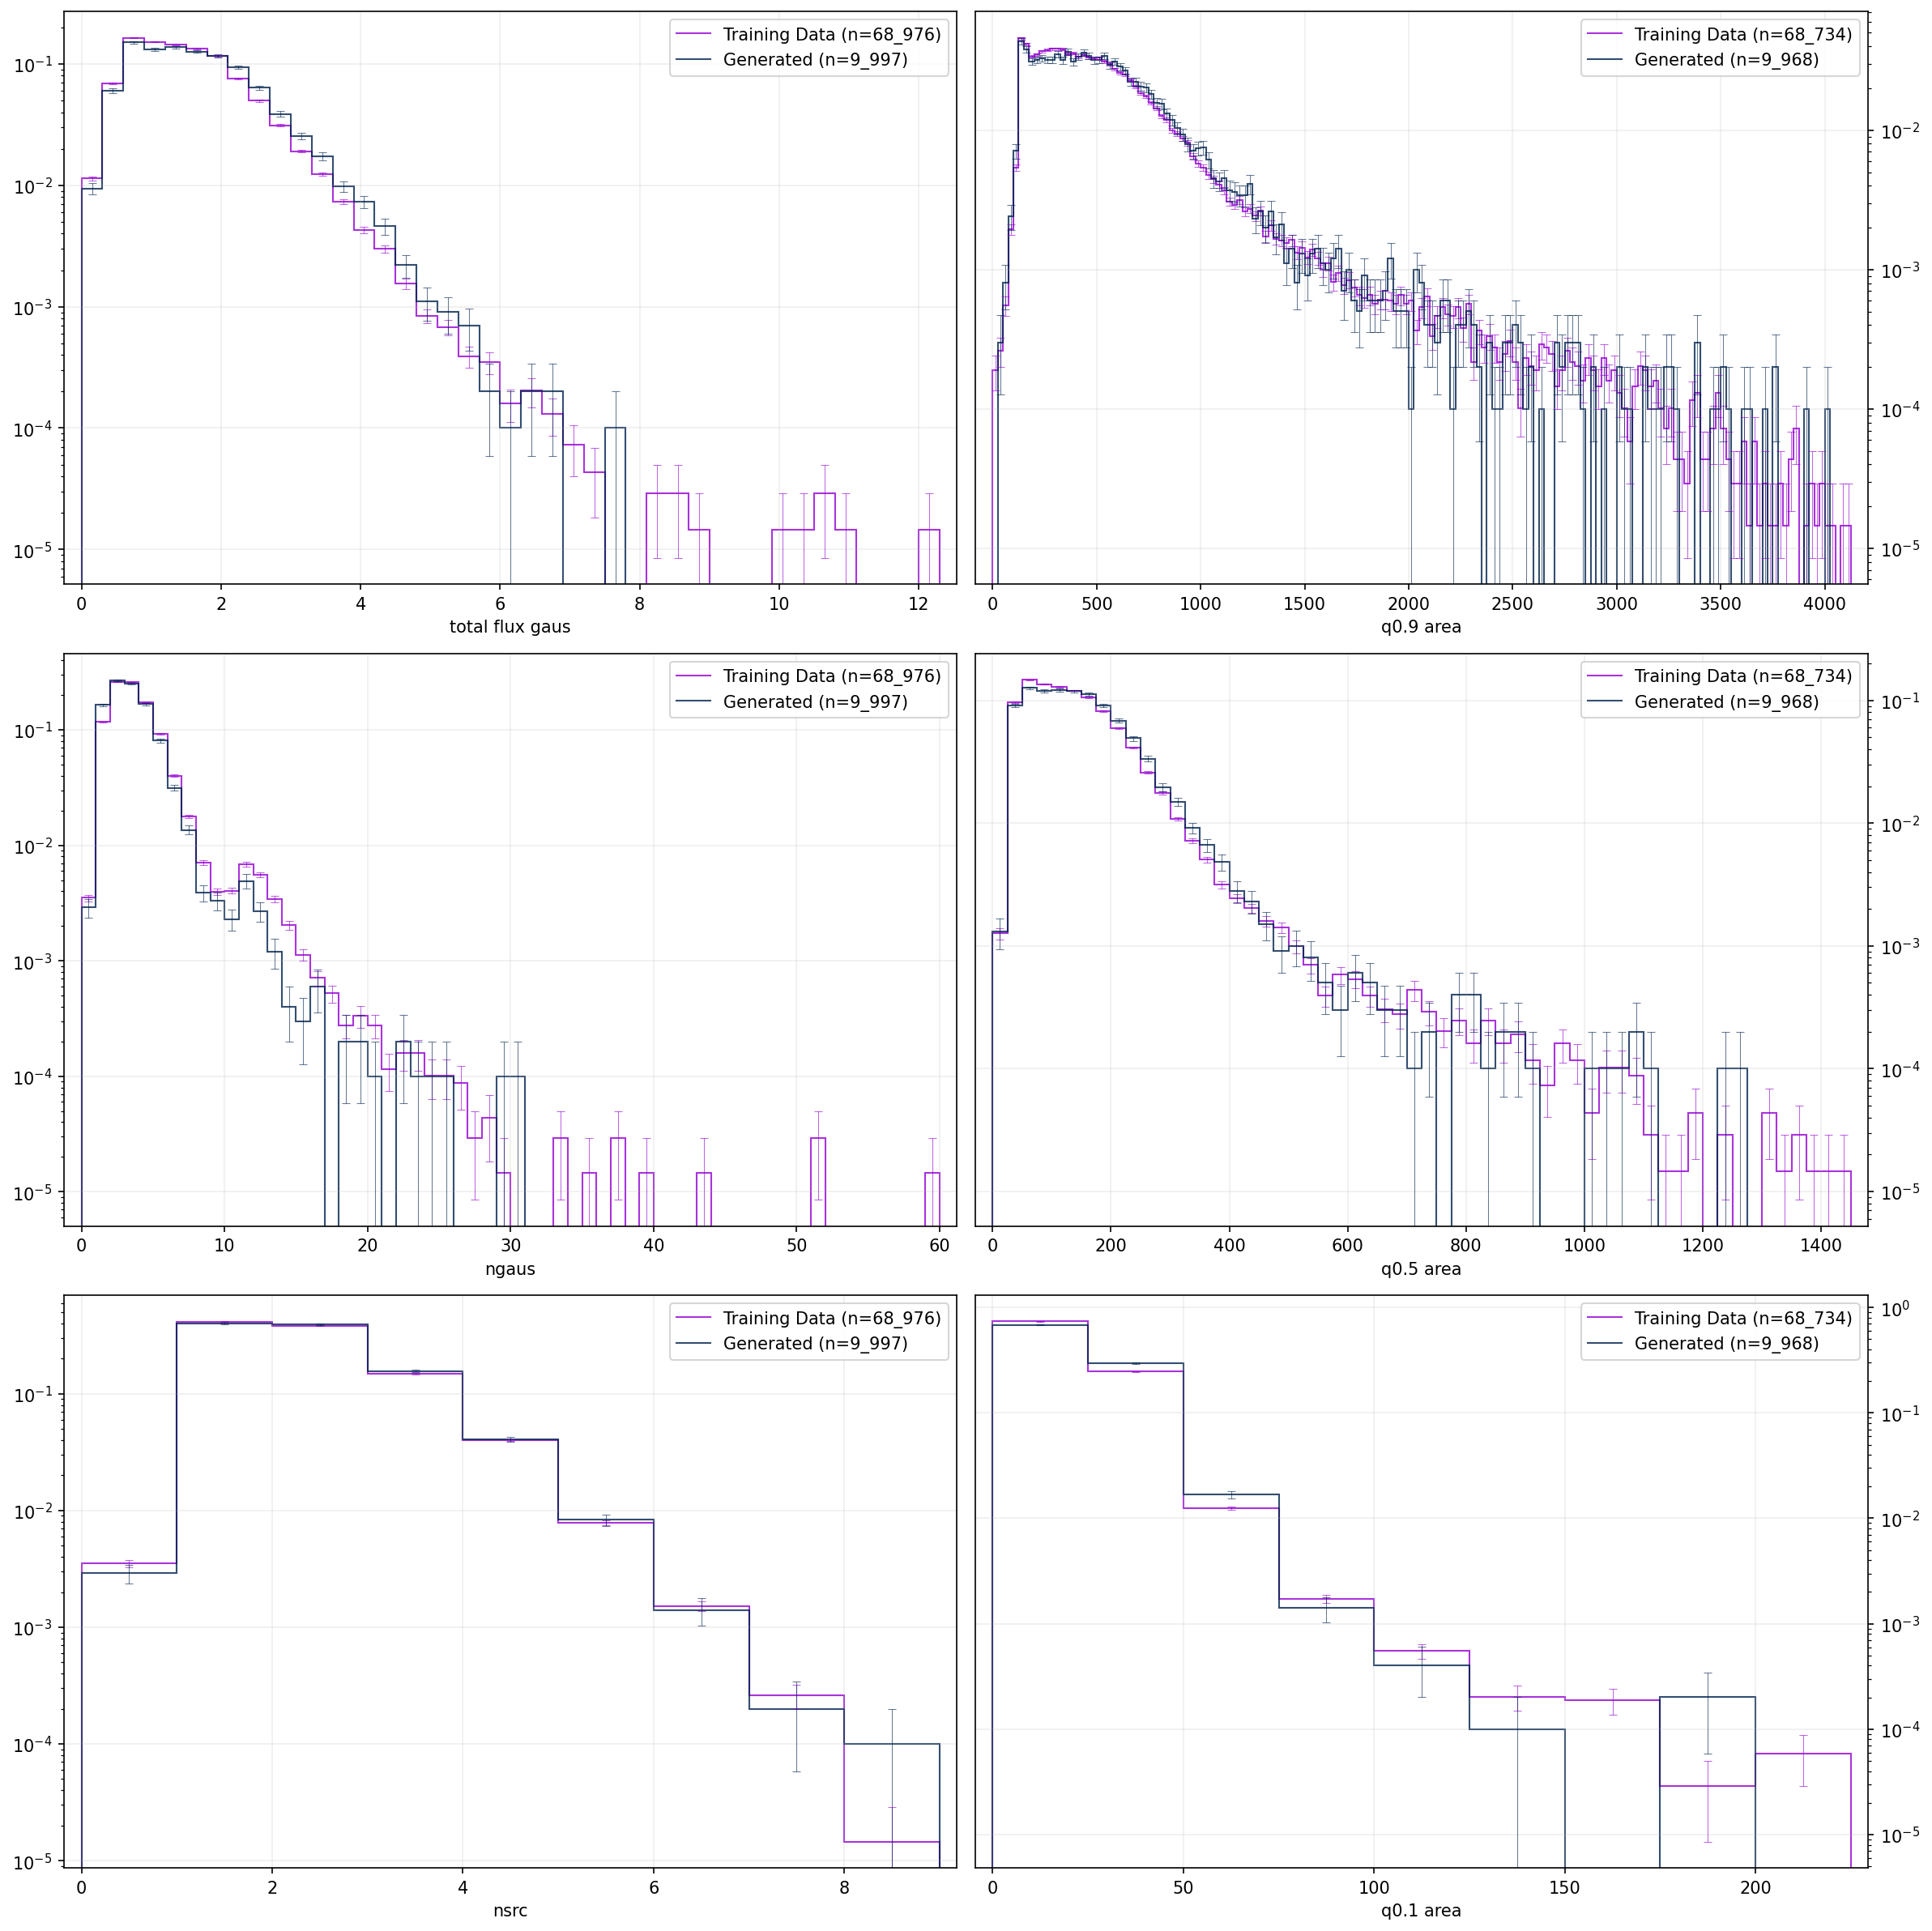

In [ ]:
from matplotlib import colormaps as cm

fig, axs = bdsf_metrics_plot(
    distributions_dict,
    label='Training Data',
    color='darkviolet',
);
fig, axs = bdsf_metrics_plot(
    gen_distributions_dict, fig_ax=(fig, axs),
    color=cm['cividis'](0),
    label='Generated'
);
fig;

In [ ]:
from utils.paths import PLAYGORUND_DIR

fig.savefig(PLAYGORUND_DIR / 'bdsf_metrics.pdf')

In [ ]:
dataset.data[idxs].shape

torch.Size([5, 80, 80])

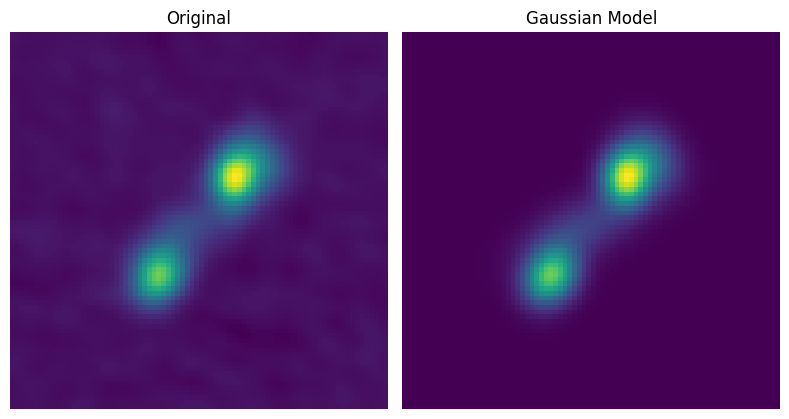

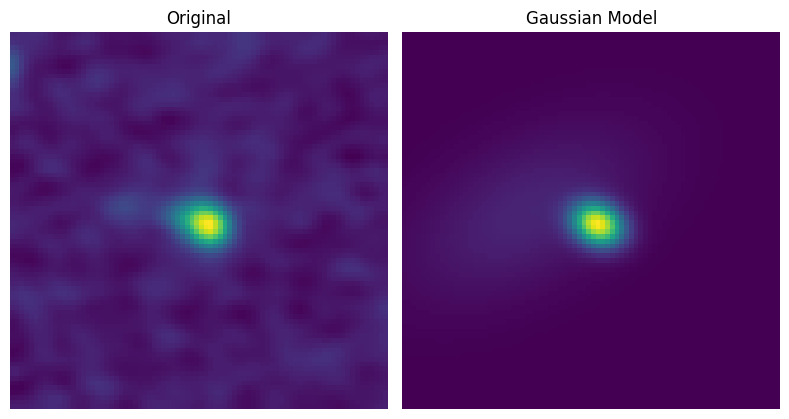

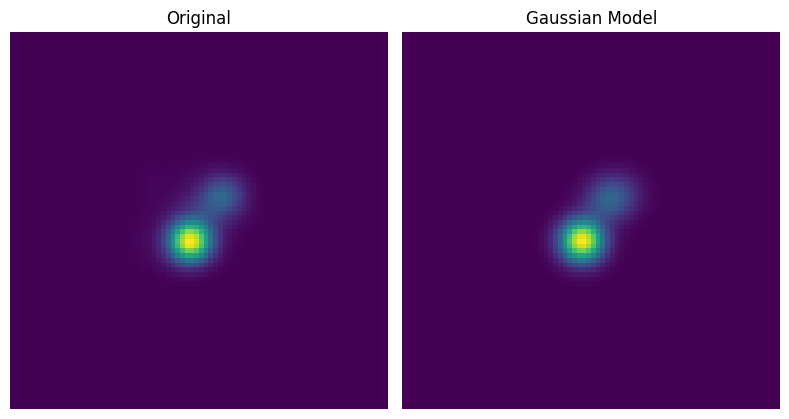

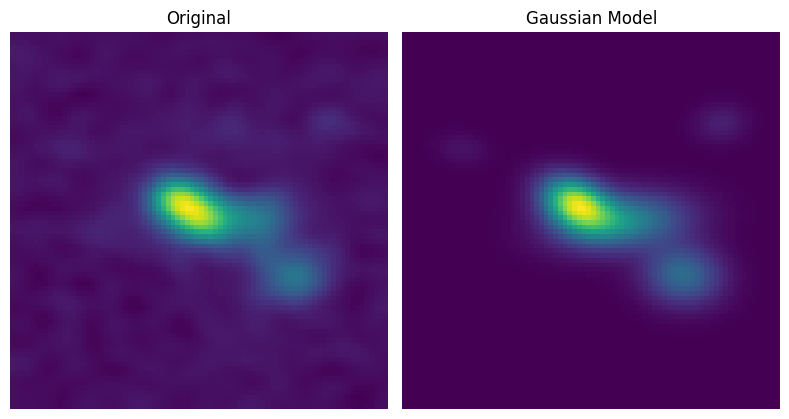

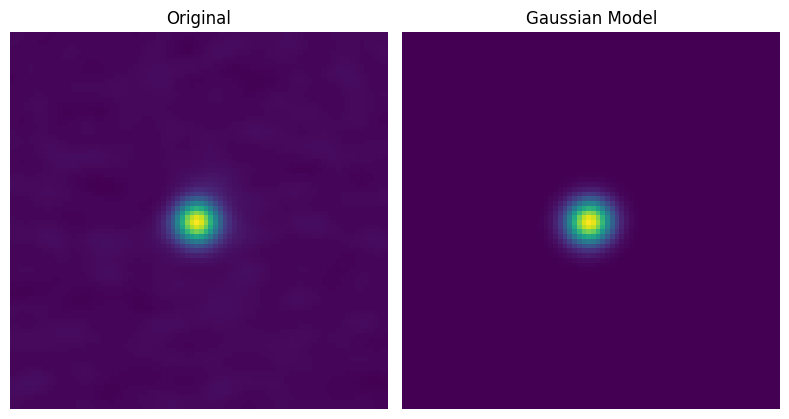

In [ ]:
# Plot some random examples with original and gaus model together
n = 5
idxs = np.random.choice(len(dataset), n, replace=False)
imgs = dataset.data[idxs].numpy()
gaus_imgs = metric_dict['model_gaus_arr'][idxs]

for i, (img, gaus_img) in enumerate(zip(imgs, gaus_imgs)):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2*n), tight_layout=True)
    axs[0].imshow(img.squeeze())
    axs[1].imshow(gaus_img.squeeze().T)

    axs[0].set_axis_off()
    axs[1].set_axis_off()

    axs[0].set_title(f'Original')
    axs[1].set_title(f'Gaussian Model')

    fig.show()

In [ ]:
def quantile_contour_plot(img_arr, p_vals=[0.9, 0.5, 0.1], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
    q_vals = quantile_values(img_arr, p_vals)

    ax.imshow(img_arr)
    ax.axis('off')
    cnt = ax.contour(
        img_arr, levels=np.unique(q_vals), colors=cm['PiYG'](p_vals), linewidths=0.5
    )
    ax.clabel(
        cnt, inline=True, fontsize=8, fmt={q: p for q, p in zip(q_vals, p_vals)}
    )
    
    if ax is None:
        plt.show()
    return q_vals

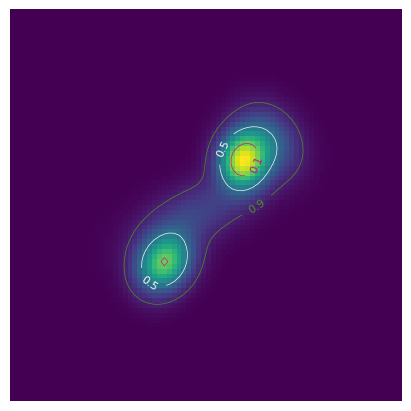

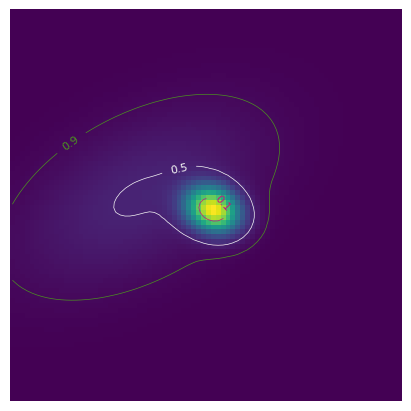

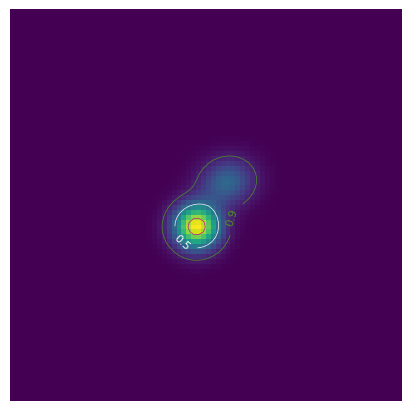

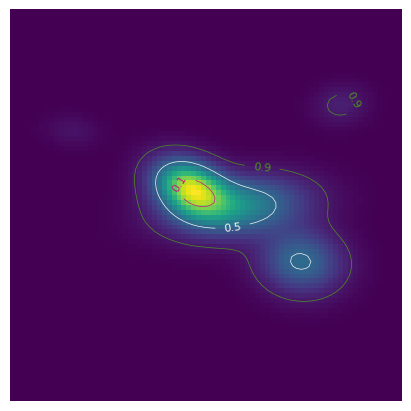

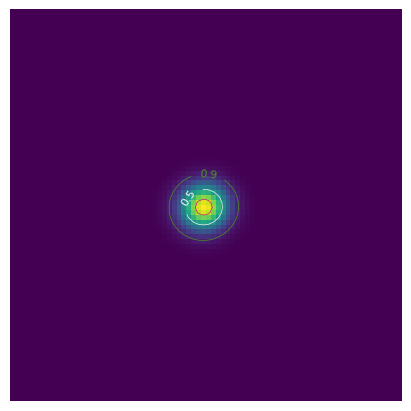

In [ ]:
for img in gaus_imgs:
    quantile_contour_plot(img.T)

## Compare SNR distributions

In [ ]:
# Import analysis results for testing
import utils.paths as paths
from utils.data_utils import EvaluationDataset

subset_path = paths.LOFAR_SUBSETS['50asLimit_SNR>=5']
dataset_train = EvaluationDataset(subset_path)
dataset_gen = EvaluationDataset(
    Path(
        '/hs/fs08/data/group-brueggen/tmartinez/diffusion/analysis_results/EDM_SNR5_50as/EDM_SNR5_50as_samples_10000Imgs_T=25.pt'
    )
)

Loading images...


Data set initialized.
Data set initialized.


In [ ]:
from astropy.stats import sigma_clipped_stats

def sigma_mask(img, threshold=5):
    _, med, std = sigma_clipped_stats(img)
    return img > med + threshold * std

def sigma_snr(img, threshold=5):
    mask = sigma_mask(img, threshold)

    if mask.sum() == 0:
        return sigma_snr(img, threshold-.5)

    if img[~mask].sum() == 0:
        print('No pixels below threshold.')
        return -1
    
    return img[mask].sum() / img[~mask].sum() * (~mask).sum() / mask.sum()

def sigma_snr_set(images, threshold=5):
    return np.array([sigma_snr(img, threshold) for img in tqdm(images, desc='\t')])

In [ ]:
# Calculate SNR
train_snr = sigma_snr_set(dataset_train)
gen_snr = sigma_snr_set(dataset_gen)

	: 100%|██████████| 10000/10000 [00:18<00:00, 554.23it/s]


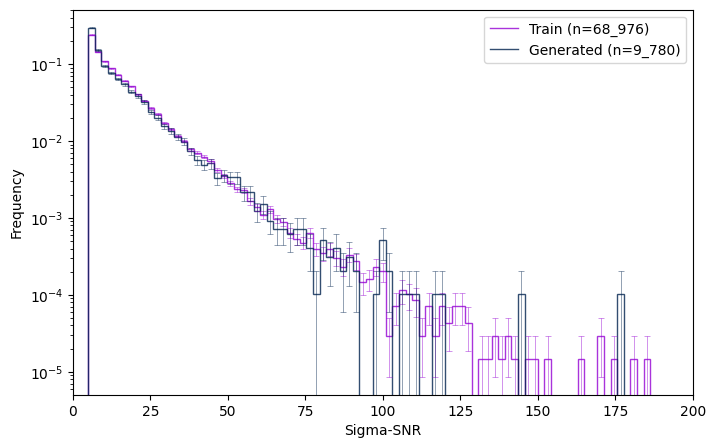

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import numpy as np

from utils.stats_utils import norm
from utils.plot_utils import add_distribution_plot

fig, ax = plt.subplots(figsize=(8, 5))

bins = 100
c_train, e_train = np.histogram(train_snr, bins=bins, density=False)
c_gen, e_gen = np.histogram(gen_snr, bins=e_train, density=False)

add_distribution_plot(
    c_train, e_train, ax, 
    label='Train', color='darkviolet', alpha=0.8
)
add_distribution_plot(
    c_gen, e_gen, ax, 
    label='Generated', color=cm['cividis'](0), alpha=0.8
)

ax.set_yscale('log')
ax.set_xlim(0, 200)
ax.set_xlabel('Sigma-SNR')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [ ]:
# Calculate 5 sigma area
train_area = sigma_area_set(train_imgs)
gen_area = sigma_area_set(gen_imgs)

	: 100%|██████████| 10000/10000 [00:00<00:00, 17449.16it/s]


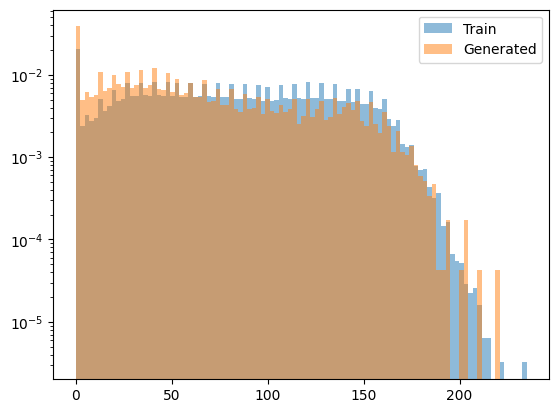

In [ ]:
import matplotlib.pyplot as plt
from utils.stats_utils import norm

fig, ax = plt.subplots()

counts, bins, _ = ax.hist(
    train_area, bins=100, alpha=0.5, label='Train', density=True
)
ax.hist(
    gen_area, bins=bins, alpha=0.5, label='Generated', density=True
)

ax.set_yscale('log')
# ax.set_xlim(0, 3000)
ax.legend()
plt.show()